# 制作数据

In [1]:
# import os
# from PIL import Image
# def transpose(read1_dir, read2_dir, write_dir):
#     file1 = os.listdir(read1_dir)
#     for file in file1:
#         file = file.split('.')[0] + '.png'
#         img = Image.open(read2_dir + file)
#         img.save(write_dir + file)
# transpose('data/images/training/', 'data/annotations/testB3/', 'data/annotations/training/')
# transpose('data/images/test/', 'data/annotations/testB3/', 'data/annotations/test/')

In [2]:
import os
import pandas as pd

train_ori_dir = 'data/images/training_ori/'
train_dir = 'data/images/training/'
test_dir = 'data/images/test/'

impost = {'f': '.jpg', 'l': '.png'}
trainfiles = [_.split('.')[0] for _ in os.listdir(train_ori_dir)]
testfiles = [_.split('.')[0] for _ in os.listdir(test_dir)]
trainmeta = pd.DataFrame({'id': trainfiles}).sort_values('id').reset_index(drop=True)
testmeta = pd.DataFrame({'id': testfiles}).sort_values('id').reset_index(drop=True)
trainmeta.head()

,id
0,1000201
1,1000202
2,1000203
3,1000204
4,1000205


样本量非常少

In [3]:
print("训练集: ", trainmeta.shape)
print("测试集: ", testmeta.shape)

训练集:  (4470, 1)
测试集:  (500, 1)


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
trainmeta.head(2)
testmeta.head(2)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

## 接下来按照测试集的格式对训练集做转化

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### 对角，上下左右拼接
  - 对角: 0
  - 上下: 1
  - 左右: 2

In [6]:
def concat_duijiao(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    top_left = img1.crop((0, 0, half_width, half_height))
    bottom_right = img1.crop((half_width, half_height, width, height))
    top_right = img2.crop((half_width, 0, width, half_height))
    bottom_left = img2.crop((0, half_height, half_width, height))
    new_image = Image.new("RGB", (width, height))

    # 粘贴裁剪后的区域到新图像
    new_image.paste(top_left, (0, 0))
    new_image.paste(top_right, (half_width, 0))
    new_image.paste(bottom_left, (0, half_height))
    new_image.paste(bottom_right, (half_width, half_height))
    return new_image

def concat_shangxia(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    new_image = Image.new("RGB", (width, height))
    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (0, half_height))
    return new_image

def concat_zuoyou(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    new_image = Image.new("RGB", (width, height))
    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (half_width, 0))
    return new_image

In [7]:
import random 
train_ori_gt_dir = 'data/annotations/training_ori/'
train_gt_dir = 'data/annotations/training/'

In [8]:
def concat_images(img1_name):
    img1 = Image.open(train_ori_dir + img1_name + impost['f'])
    img2_name = random.choice(trainmeta['id'])
    img2 = Image.open(train_ori_dir + img2_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img1_name + impost['l'])
    img2_gt = Image.open(train_ori_gt_dir + img2_name + impost['l'])

    new_image = concat_duijiao(img1, img2)
    new_image_gt = concat_duijiao(img1_gt, img2_gt)

    new_image.save(train_dir + '0' + img1_name + '.jpg')
    new_image_gt.save(train_gt_dir + '0' + img1_name + '.png')

In [9]:
def concat_images_double(img1_name):
    img1 = Image.open(train_ori_dir + img1_name + impost['f'])
    im2_name = random.choice(trainmeta['id'])
    img2 = Image.open(train_ori_dir + im2_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img1_name + impost['l'])
    img2_gt = Image.open(train_ori_gt_dir + im2_name + impost['l'])

    # 上下拼接
    new_image = concat_shangxia(img1, img2)
    new_image_gt = concat_shangxia(img1_gt, img2_gt)
    new_image.save(train_dir + '1' + img1_name + '.jpg')
    new_image_gt.save(train_gt_dir + '1' + img1_name + '.png')
    
    # 左右拼接
    new_image = concat_zuoyou(img1, img2)
    new_image_gt = concat_zuoyou(img1_gt, img2_gt)
    new_image.save(train_dir + '2' + img1_name + '.jpg')
    new_image_gt.save(train_gt_dir + '2' + img1_name + '.png')

### 生成不规则图像的图片

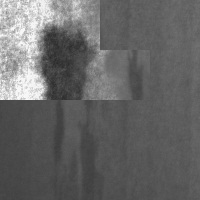

In [16]:
import cv2
def overlay(img_name):
    background = cv2.imread(f'data/images/training_ori/{img_name}.jpg', cv2.IMREAD_GRAYSCALE)
    random_img = random.choice(trainmeta['id'])
    overlay = cv2.imread(f'data/images/training_ori/{random_img}.jpg', cv2.IMREAD_GRAYSCALE)

    # 调整小图像的大小，若需要可以指定更小尺寸
    positions = [(0, 0, 100, 100), (100, 50, 150, 100)]  # 调整为你需要的叠加位置

    # 创建一个彩色版本的背景用于合并显示
    background_color = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)

    # 不规则拼接：循环每个位置，将未缩放的小图像叠加到背景图上
    for pos in positions:
        start_x, start_y, end_x, end_y = pos

        # 计算叠加区域的边界，确保 overlay 不超出背景图像的边界

        # 对 overlay 进行裁剪以匹配 ROI 的尺寸
        overlay_cropped = overlay[start_y:end_y, start_x:end_x]
        overlay_color = cv2.cvtColor(overlay_cropped, cv2.COLOR_GRAY2BGR)

        # 提取背景中的 ROI
        roi = background_color[start_y:end_y, start_x:end_x]

        # 创建遮罩，将非零区域的值设为 255
        mask = np.ones_like(overlay_cropped, dtype=np.uint8) * 255

        # 使用遮罩将 overlay 不规则地叠加到背景图上
        np.copyto(roi, overlay_color, where=(mask[..., None] == 255))
    background_color = Image.fromarray(cv2.cvtColor(background_color, cv2.COLOR_BGR2RGB))
    return background_color

overlay(trainmeta['id'][0])

### 椒盐
   - 命名以 3 开头
   - 椒盐比: 0.039, 8.8, 0.432

In [36]:
def add_salt_pepper_noise(img, pepper_salt_prob=0.039, salt_vs_pepper=[0.432, 8.8]):
    """
    向图像添加椒盐噪声。
    
    参数:
    - img (Image): 输入图像。
    - salt_prob (float): 椒盐噪声中盐的概率。
    - pepper_prob (float): 椒盐噪声中椒的概率。

    返回:
    - Image: 添加椒盐噪声后的图像。
    """
    img_array = np.array(img)
    total_pixels = img_array.size

    total_prob = random.uniform(pepper_salt_prob - 0.01, 0.15)
    salt_vs_pepper = random.uniform(salt_vs_pepper[0] + 0.01, salt_vs_pepper[1] - 0.01)
    salt_vs_pepper = np.array([salt_vs_pepper, 1.0])
    salt_vs_pepper = salt_vs_pepper / np.sum(salt_vs_pepper)
    salt_prob = total_prob * salt_vs_pepper[0]
    pepper_prob = total_prob * salt_vs_pepper[1]

    # 添加盐噪声
    num_salt = max(int(salt_prob * total_pixels) - np.sum(img_array == 255), 0)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in img_array.shape]
    img_array[salt_coords[0], salt_coords[1]] = 255    # 设置为白色（盐）

    # 添加椒噪声
    num_pepper = max(int(pepper_prob * total_pixels) - np.sum(img_array == 0), 0)
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in img_array.shape]
    img_array[pepper_coords[0], pepper_coords[1]] = 0  # 设置为黑色（椒）

    return Image.fromarray(img_array)

def images_add_noise(img_name):
    img1 = Image.open(train_ori_dir + img_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img_name + impost['l'])

    new_image = add_salt_pepper_noise(img1)
    new_image.save(train_dir + '3' + img_name + '.jpg')
    img1_gt.save(train_gt_dir + '3' + img_name + '.png')

In [14]:
trainmeta['id'].apply(concat_images)
trainmeta['id'].apply(concat_images_double)
trainmeta['id'].apply(images_add_noise)

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

### 生成原图

In [15]:
def original(img_name):
    img1 = Image.open(train_ori_dir + img_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img_name + impost['l'])

    img1.save(train_dir + '4' + img_name + '.jpg')
    img1_gt.save(train_gt_dir + '4' + img_name + '.png')

In [16]:
trainmeta['id'].apply(original)

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

In [17]:
new_csv = os.listdir('data/images/training')

In [18]:
new_csv = [x.split('.')[0] for x in new_csv]
train_new_meta = pd.DataFrame({'id':new_csv})
train_new_meta.head()

,id
0,21000629
1,11002576
2,31000675
3,21002029
4,31003603


In [19]:
train_new_meta.to_csv('stats/train-meta.csv', index=False)

In [20]:
make_files = [_.split('.')[0] for _ in os.listdir(train_dir)]
train_new_meta = pd.DataFrame({'id': make_files}).sort_values('id').reset_index(drop=True)
train_new_meta.head()

,id
0,01000201
1,01000202
2,01000203
3,01000204
4,01000205


In [21]:
train_new_meta.to_csv('stats/train-meta.csv', index=False)
testmeta.to_csv('stats/test-meta.csv', index=False)

In [22]:
train_new_meta.shape
testmeta.shape

(22350, 1)

(500, 1)